In [ ]:
## purpose: Calculate intron length and plot - Figure 6D
##  Input: coords from script 5, blocks from script 3, all_intron_length.csv from script 14

In [24]:
# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu


In [25]:
coords = pd.read_csv('exon_block_coordinates_ups_dns.csv')
block =pd.read_csv('block_exons_ddPSImax0.2_adjacent.csv')
all = pd.read_csv('all_whippet_detected_intron_length.csv')

In [26]:
coords.head()

,chr,gene_name,block_start,block_end,strand,number_of_exons,block_coord,start_ups_exon,end_ups_exon,start_dns_exon,end_dns_exon
0,chr4,AADAT,170066414,170068687,-,3,chr4:170066414-170068687,170064719,170064825,170069148,170069230
1,chr4,AASDH,56351342,56353596,-,2,chr4:56351342-56353596,56349263,56350058,56354039,56354211
2,chr17,AATF,36950214,36953907,+,3,chr17:36950214-36953907,36948954,36949216,36986617,36986731
3,chr17,ABCA5,69264735,69270750,-,3,chr17:69264735-69270750,69261635,69261748,69271162,69271289
4,chr1,ABCB10,229525936,229530408,-,3,chr1:229525936-229530408,229521592,229521635,229531636,229531731


In [27]:
# --- Functions to compute upstream and downstream intron lengths ---
def compute_upstream_intron(row):
    """
    Compute the length of the upstream intron between the upstream exon and the block.
    """
    if pd.isna(row['end_ups_exon']) or pd.isna(row['block_start']) or pd.isna(row['block_end']):
        return np.nan

    if row['strand'] == '+':
        intron = row['block_start'] - row['end_ups_exon']
    else:
        intron = row['end_ups_exon'] - row['block_end']

    return intron if intron >= 0 else np.nan

def compute_downstream_intron(row):
    """
    Compute the length of the downstream intron between the block and the downstream exon.
    """
    if pd.isna(row['start_dns_exon']) or pd.isna(row['block_end']) or pd.isna(row['block_start']):
        return np.nan

    if row['strand'] == '+':
        intron = row['start_dns_exon'] - row['block_end']
    else:
        intron = row['block_start'] - row['start_dns_exon']

    return intron if intron >= 0 else np.nan

# --- Apply corrected logic ---
coords['intron_length_up'] = coords.apply(compute_upstream_intron, axis=1)
coords['intron_length_dn'] = coords.apply(compute_downstream_intron, axis=1)




In [28]:
# --- Functions to compute block internal intron lengths ---

# --- Ensure Coord is string ---
block['Coord'] = block['Coord'].astype(str)

# --- Initialize intron_length ---
block['intron_length'] = np.nan

# --- Extract start/end positions from Coord ---
def extract_positions(coord):
    chrom, positions = coord.split(':')
    start, end = map(int, positions.split('-'))
    return start, end

# --- Main intron length calculation for internal exons within blocks ---
def compute_intron_length_block(df):
    intron_updates = {}

    for i, row in df.iterrows():
        gene_name = row['gene_name']
        exon_number = row['exon_number']
        delta_psi = row['DeltaPsi']

        # Find neighboring exons (adjacent and similar dPSI) in same gene
        neighbors = df[
            (df['gene_name'] == gene_name) &
            (abs(df['exon_number'] - exon_number) == 1) &
            (abs(df['DeltaPsi'] - delta_psi) <= 0.02)
        ]

        for _, neighbor in neighbors.iterrows():
            # Determine upstream vs downstream by exon number
            if neighbor['exon_number'] < exon_number:
                upstream_row, downstream_row = neighbor, row
            else:
                upstream_row, downstream_row = row, neighbor

            upstream_start, upstream_end = extract_positions(upstream_row['Coord'])
            coord_start, coord_end = extract_positions(downstream_row['Coord'])

            if row['Strand'] == '+':
                intron_length = coord_start - upstream_end
            else:
                intron_length = upstream_start - coord_end

            # Accept only positive values
            if intron_length < 0:
                intron_length = np.nan

            # Assign intron length to the smaller exon number
            smaller_coord = upstream_row['Coord'] if upstream_row['exon_number'] < downstream_row['exon_number'] else downstream_row['Coord']
            intron_updates[smaller_coord] = intron_length

    # Update all at once
    for coord, length in intron_updates.items():
        df.loc[df['Coord'] == coord, 'intron_length'] = length

    return df

# --- Apply function to your DataFrame ---
block = compute_intron_length_block(block)


In [29]:
# --- Build Plot Data ---

# Build plotting DataFrames
up_df = coords[['chr', 'gene_name', 'intron_length_up']].dropna().rename(columns={'intron_length_up': 'intron_length'})
up_df['Category'] = 'up'

dn_df = coords[['chr', 'gene_name', 'intron_length_dn']].dropna().rename(columns={'intron_length_dn': 'intron_length'})
dn_df['Category'] = 'dn'

block_df = block[['Coord', 'intron_length']].dropna().copy()
block_df['Category'] = 'block'

all_df = all[['Coord', 'intron_length']].dropna().copy()
all_df['Category'] = 'all'

# Combine and convert to kb
plot_df = pd.concat([up_df, dn_df, block_df, all_df], ignore_index=True)
plot_df['intron_length_kb'] = plot_df['intron_length'] / 1000



/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_85329/2457252805.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


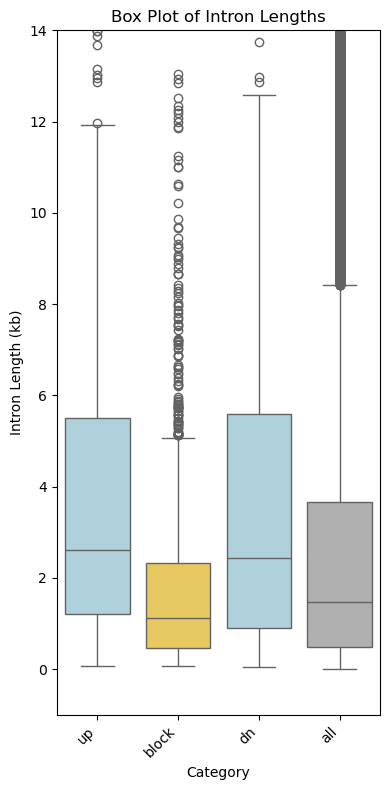

In [31]:
# --- Define Custom Colors 

# Set categorical order
category_order = ["up", "block", "dn", "all"]

# Define custom colors for each category
custom_colors = {
    "up": "#A8D5E2",       # Light Blue
    "dn": "#A8D5E2",       # Light Blue
    "block": "#FFD449",    # Yellow
    "all": "#B0B0B0"       # Gray
}

# Create ordered palette list
ordered_palette = [custom_colors[cat] for cat in category_order]

# Plot
plt.figure(figsize=(4, 8))
sns.boxplot(
    x="Category",
    y="intron_length_kb",
    data=plot_df,
    order=category_order,
    palette=ordered_palette
)

plt.xticks(rotation=45, ha="right")
plt.title("Box Plot of Intron Lengths")
plt.ylim(-1, 14)
plt.xlabel("Category")
plt.ylabel("Intron Length (kb)")
plt.tight_layout()

plt.savefig('intron_length.pdf')
plt.show()


In [23]:
# --- Perform Mann-Whitney U Tests ---

# Extract intron length arrays
intron_length_values = {
    cat: plot_df.loc[plot_df['Category'] == cat, 'intron_length'].dropna().values
    for cat in plot_df['Category'].unique()
}

# List of all pairs for comparison
comparisons = list(combinations(intron_length_values.keys(), 2))
num_tests = len(comparisons)

# Perform tests
p_values = []

for (cat1, cat2) in comparisons:
    data1 = intron_length_values[cat1]
    data2 = intron_length_values[cat2]

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        p_corrected = min(p * num_tests, 1.0)

        p_values.append({
            "Category 1": cat1,
            "Category 2": cat2,
            "Raw p-value": p,
            "Bonferroni-corrected p-value": p_corrected
        })

# Display p-values
p_values_df = pd.DataFrame(p_values)
print(p_values_df)


  Category 1 Category 2    Raw p-value  Bonferroni-corrected p-value
0         up         dn   8.486933e-01                  1.000000e+00
1         up      block   4.615031e-54                  2.769019e-53
2         up        all  5.661941e-125                 3.397164e-124
3         dn      block   1.024476e-61                  6.146857e-61
4         dn        all  1.068978e-137                 6.413866e-137
5      block        all   1.129166e-14                  6.774998e-14
